In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import linear_model

ejemplo:

# ¿cuántas horas tengo que estudiar para aprobar Astrometría?

<br>

In [3]:
N = stats.norm(loc=50, scale=20)
x = N.rvs(size=50)
x = np.maximum(x, 0)

In [4]:
def fnoise(x):
    y = 0.012*(x-30) + 0.25
    noise = stats.norm(loc=0, scale=0.15).rvs(size=len(x))
    z = y + noise
    z = np.minimum(1., z)
    z = np.maximum(0., z)
    return z

In [5]:
y = fnoise(x)

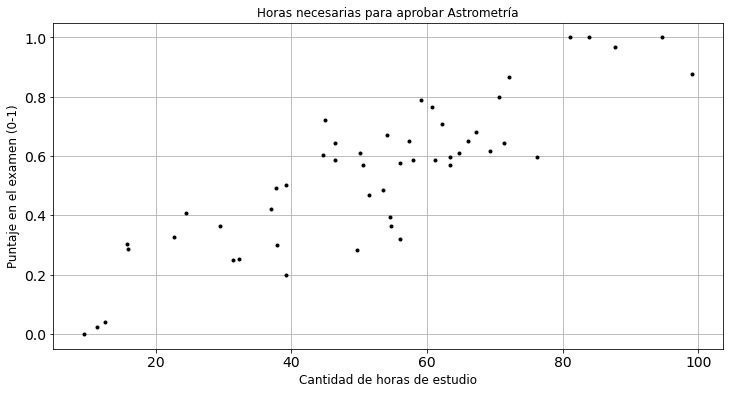

In [6]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(x, y, 'k.')
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid()

In [7]:
aprueba = y > 0.6

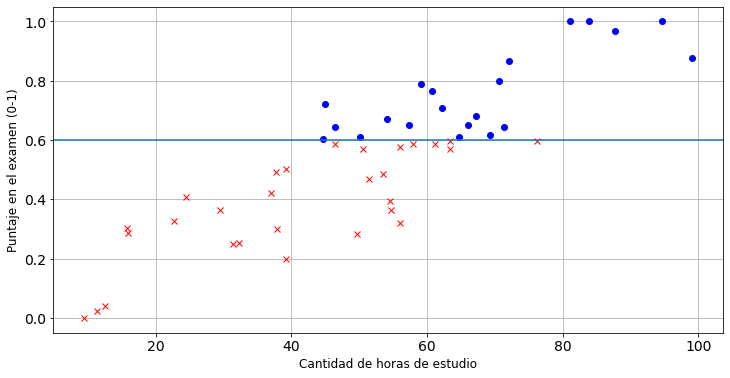

In [8]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(x[aprueba], y[aprueba], 'bo')
ax.plot(x[~aprueba], y[~aprueba], 'rx')
ax.axhline(0.6)
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid()

Ahora, ¿se puede predecir si un alumno va a aprobar según cuántas horas haya estudiado?

Una posibilidad es hacer una...

## regresión lineal

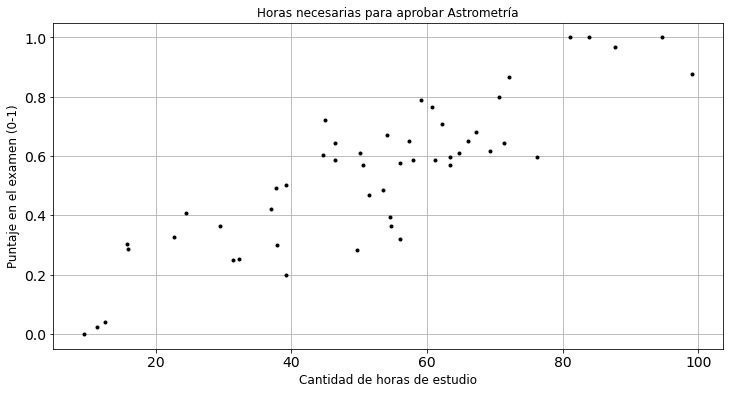

In [49]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(x, y, 'k.')
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid()

In [10]:
model = linear_model.LinearRegression()
X, Y = x.reshape(-1, 1), y.reshape(-1, 1)
model.fit(X, Y)

LinearRegression()

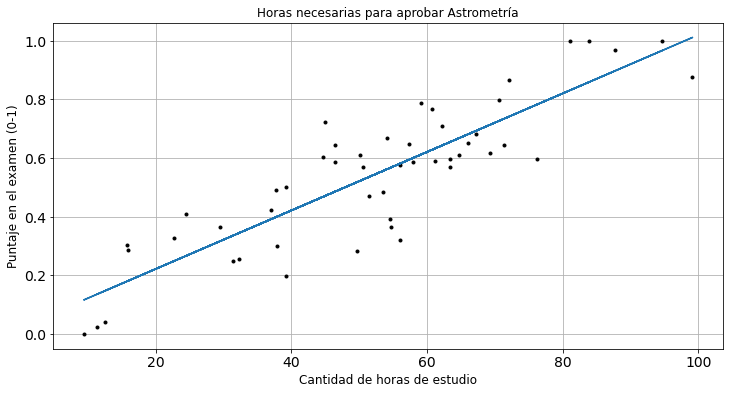

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(x, y, 'k.')
ax.plot(X, model.predict(X))
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid()

Esto es equivalente a establecer un valor crítico de $$t="horas~de~estudio"$$

para el cual se determina si un alumno aprueba o no. 

Supongamos que ese es el modelo, y queremos VALIDARLO, es decir, medir su capacidad de predicción.

Vamos a ir recorriendo los valores de umbral para medir la fracción de falsos positivos y falsos negativos

Por ejemplo, si elegimos como umbral t="50 dias", tenemos:

In [64]:
xc = [[57]]   # <---- este es el parámetro del modelo
yc = model.predict(xc)

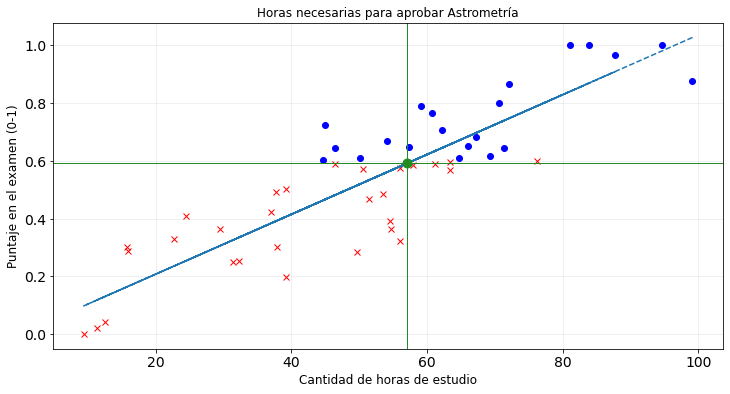

In [65]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(x[aprueba], y[aprueba], 'bo')
ax.plot(x[~aprueba], y[~aprueba], 'rx')
ax.plot(X, model.predict(X), linestyle='--')
ax.plot(xc, yc, marker='o', markersize=9, color='forestgreen')
ax.axhline(yc, color='forestgreen', linewidth=1)
ax.axvline(xc, color='forestgreen', linewidth=1)
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid(color='silver', alpha=0.3)

De los puntos que el modelo (umbral) predice que aprueban, aprueba una fracción, y viceversa.

Recordemos que existen varias métricas para medir eso:

<img src="./plots/confusion_matrix.png" width=250 />

In [66]:
# de todos los que son positivos (aprueban), ¿qué fracción detecto?
TPR = ((y>0.6) & (y>yc)).sum()/(y>0.6).sum()
print(f'positivos reales: {(y>0.6).sum()}')
print(f'de esos, predichos positivos: {((y>0.6) & (y>yc)).sum()}')
print(f'TPR: {TPR:.3f}')

positivos reales: 21
de esos, predichos positivos: 21
TPR: 1.000


<img src="./plots/recall.png" width=600 />

In [67]:
# de todos los que que son negativos, ¿qué fracción está mal?
FPR = ((y<0.6) & (y>yc)).sum()/(y<0.6).sum()
print(f'negativos reales: {(y<0.6).sum()}')
print(f'de esos, los predichos positivos (mal): {((y<0.6) & (y>yc)).sum()}')
print(f'FPR: {FPR:.3f}')

negativos reales: 29
de esos, los predichos positivos (mal): 2
FPR: 0.069


<img src="./plots/FPR.png" width=600 />

lo ideal sería TPR=1, FPR=0, ¿se puede?...
<br><br><br>

Ahora veamos para distintos valores del umbral:

In [16]:
tprs = []
fprs = []
t = np.arange(20, 90)
for i in t:
    xc = [[i]]
    yc = model.predict(xc)
    
    TPR = ((y>0.6) & (y>yc)).sum()/(y>0.6).sum()    
    tprs.append(TPR)
    
    FPR = ((y<0.6) & (y>yc)).sum()/(y<0.6).sum()
    fprs.append(FPR)

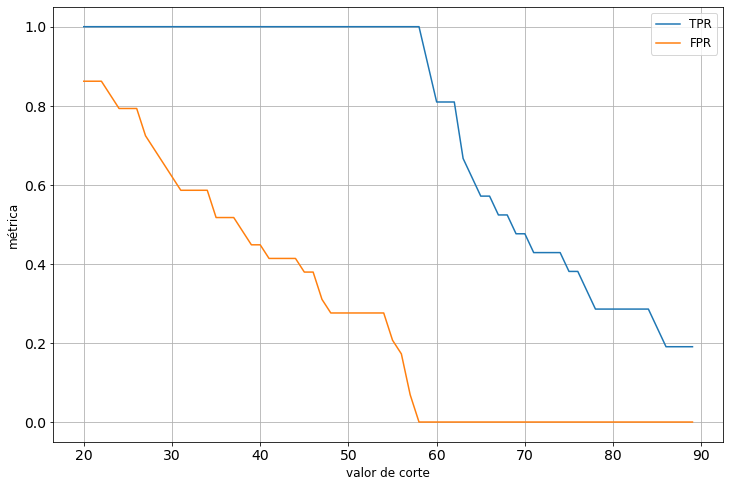

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(t, tprs, label='TPR')
ax.plot(t, fprs, label='FPR')
ax.set_xlabel('valor de corte')
ax.set_ylabel('métrica')
ax.legend()
ax.grid()

Esto pasa porque estamos considerando un solo conjunto, y básicamente estamos encontrando la intersección del modelo con la línea de 0.6 puntos.

Para evaluar la capacidad de predicción del modelo, hay que volver a considerar los conjuntos de entrenamiento y prueba.

Vamos a armar los conjuntos de entrenamiento y de prueba, con un 70% para entrenamiento.

In [79]:
from sklearn.model_selection import train_test_split

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [133]:
ap_train = y_train > 0.6
ap_test = y_test > 0.6

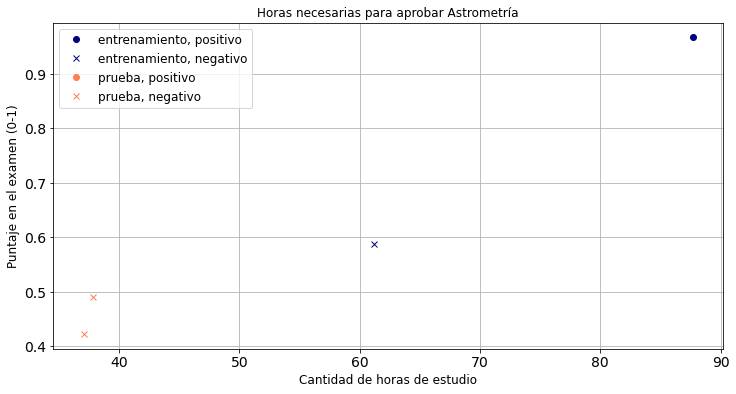

In [134]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(X_train[ap_train], y_train[ap_train], marker='o', color='navy', linestyle='None', label='entrenamiento, positivo')
ax.plot(X_train[~ap_train], y_train[~ap_train], marker='x', color='navy', linestyle='None', label='entrenamiento, negativo')
ax.plot(X_test[ap_test], y_test[ap_test], marker='o', color='coral', linestyle='None', label='prueba, positivo')
ax.plot(X_test[~ap_test], y_test[~ap_test], marker='x', color='coral', linestyle='None', label='prueba, negativo')
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.legend()
ax.grid()

1) entrenamos con el conjunto de entrenamiento:

In [135]:
model = linear_model.LinearRegression()
X, Y = X_train.reshape(-1, 1), y_train.reshape(-1, 1)
model.fit(X, Y)

LinearRegression()

In [136]:
aprueba = y_train > 0.6

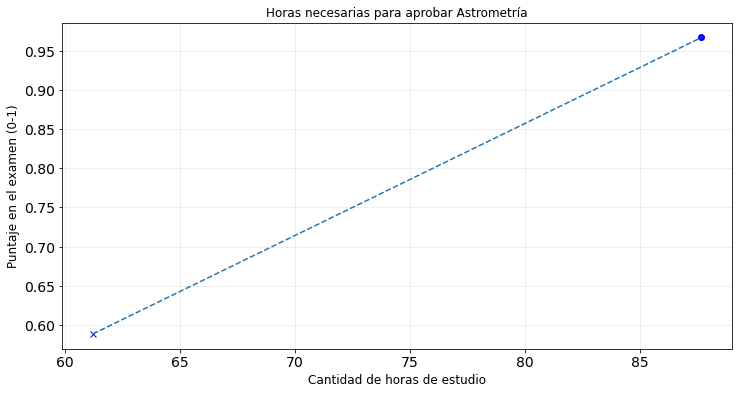

In [137]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(X_train[aprueba], y_train[aprueba], 'bo')
ax.plot(X_train[~aprueba], y_train[~aprueba], 'bx')
ax.plot(X, model.predict(X), linestyle='--')
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid(color='silver', alpha=0.3)

Ahora con ese modelo, vemos que pasa con el conjunto de prueba:

In [138]:
aprueba = y_test > 0.6

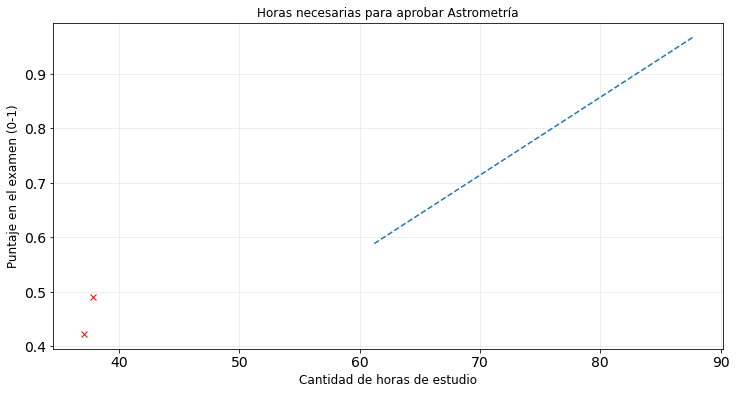

In [139]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(X_test[aprueba], y_test[aprueba], 'ro')
ax.plot(X_test[~aprueba], y_test[~aprueba], 'rx')
ax.plot(X, model.predict(X), linestyle='--')
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid(color='silver', alpha=0.3)

Volvemos a construir las métricas, pero con los datos de prueba

In [140]:
tprs = []
fprs = []
t = np.arange(20, 90)
for i in t:
    xc = [[i]]
    yc = model.predict(xc)
    
    TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()    
    tprs.append(TPR)
    
    FPR = ((y_test<0.6) & (y_test>yc)).sum()/(y_test<0.6).sum()
    fprs.append(FPR)

/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()
/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()
/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()
/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()
/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()
/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((y_test>0.6) & (y_test>yc)).sum()/(y_test>0.6).sum()
/tmp/ipykernel_11804/4090605802.py:8: RuntimeWarning

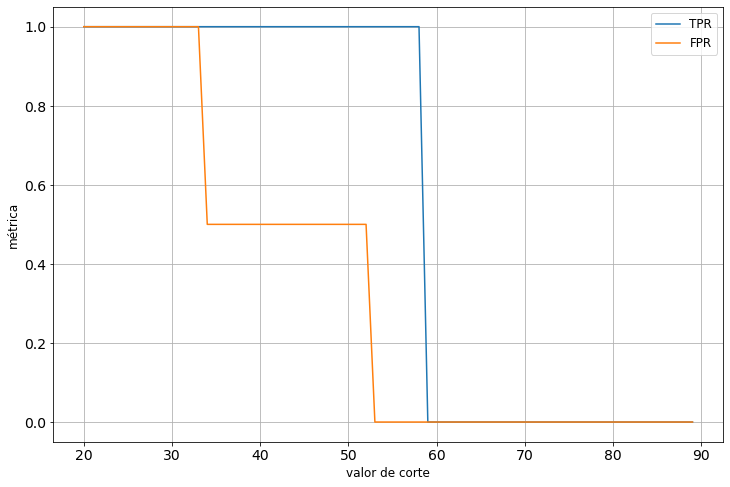

In [131]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(t, tprs, label='TPR')
ax.plot(t, fprs, label='FPR')
ax.set_xlabel('valor de corte')
ax.set_ylabel('métrica')
ax.legend()
ax.grid()

Ahora el corte da un poco distinto pero sigue andando bien!

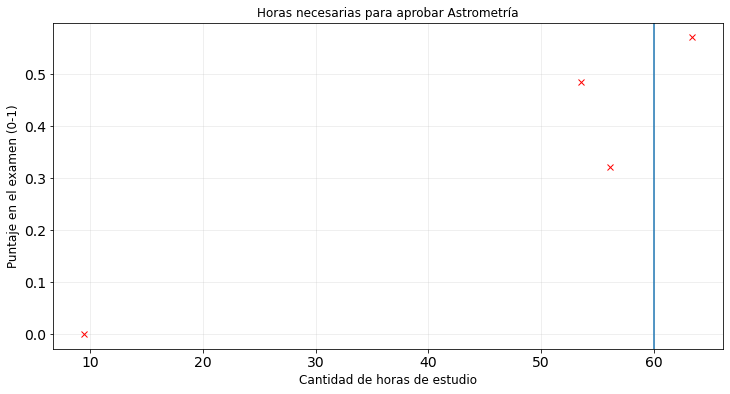

In [118]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(X_test[aprueba], y_test[aprueba], 'ro')
ax.plot(X_test[~aprueba], y_test[~aprueba], 'rx')
ax.axvline(60)
ax.set_title('Horas necesarias para aprobar Astrometría')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('Puntaje en el examen (0-1)')
ax.grid(color='silver', alpha=0.3)

Supongamos ahora que tenemos **solamente un dato**, la cantidad de horas de estudio, y una etiqueta, si aprueba o no.

Es decir, el corte se debe hacer sobre el eje X directamente, ya no tenemos un modelo.

Hagamos un clasificador muy simple, y calculemos las métricas.

In [119]:
tprs = []
fprs = []
t = np.arange(20, 90)
for xc in t:
   
    TPR = ((X_test>xc) & (y_test>0.6)).sum()/(y_test>0.6).sum()    
    tprs.append(TPR)
    
    FPR = ((X_test>xc) & (y_test<0.6)).sum()/(y_test<0.6).sum()
    fprs.append(FPR)

/tmp/ipykernel_11804/709892208.py:6: RuntimeWarning: invalid value encountered in long_scalars
  TPR = ((X_test>xc) & (y_test>0.6)).sum()/(y_test>0.6).sum()


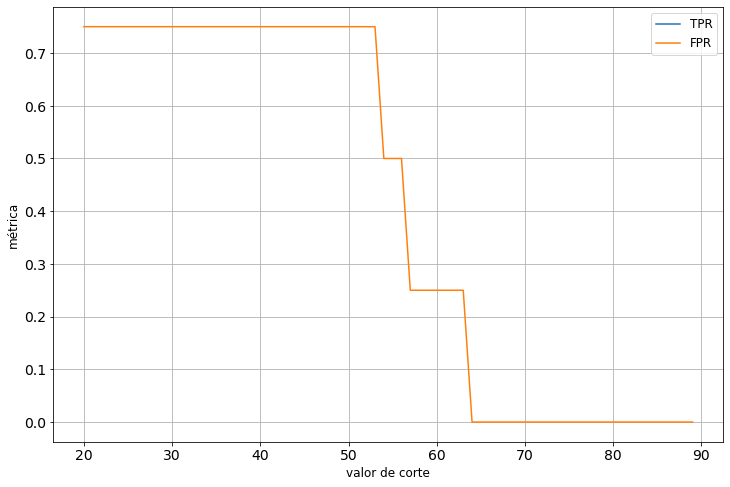

In [120]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(t, tprs, label='TPR')
ax.plot(t, fprs, label='FPR')
ax.set_xlabel('valor de corte')
ax.set_ylabel('métrica')
ax.legend()
ax.grid()

Grafiquemos uno en función del otro:

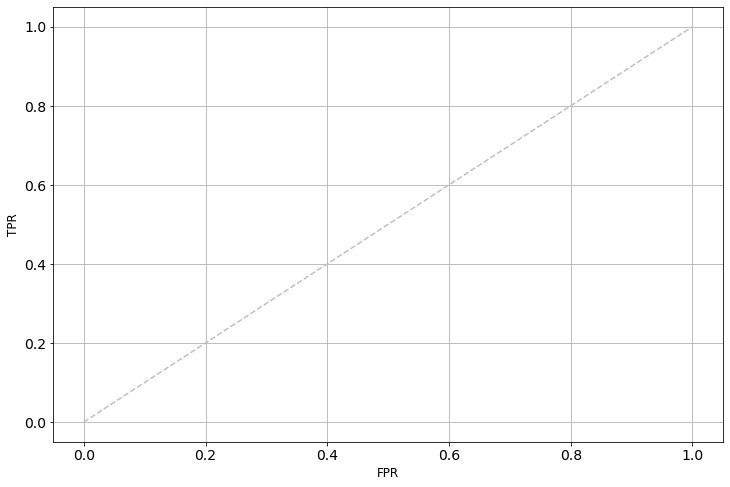

In [121]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(fprs, tprs, 'kx')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0,1], [0,1], linestyle='--', color='silver')
ax.grid()

Ahora, queremos asignarle no una etiqueta (aprobado, no aprobado), sino una PROBABILIDAD de que apruebe.

## Regresión logística

In [142]:
yl = np.array([0. if yy<0.6 else 1. for yy in y])

In [143]:
aprueba = y > 0.6

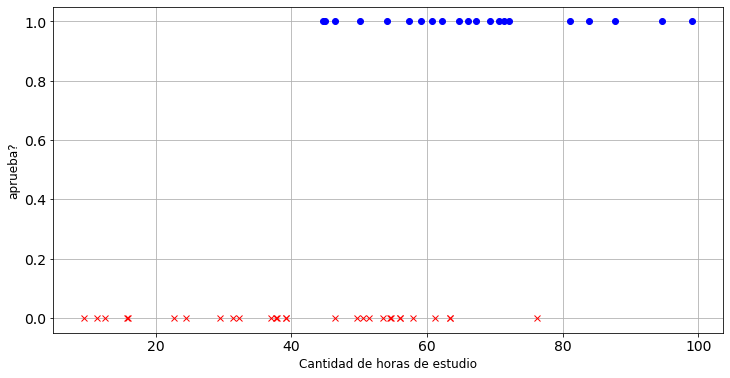

In [144]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(x[aprueba], yl[aprueba], 'bo')
ax.plot(x[~aprueba], yl[~aprueba], 'rx')
ax.set_xlabel('Cantidad de horas de estudio')
ax.set_ylabel('aprueba?')
ax.grid()

Usamos una función que se denomina "función logística"

In [36]:
def logistic(x):
    return 1 / (1+np.exp(-x))

In [37]:
xx = np.linspace(-4, 4, 20)
yy = logistic(xx)

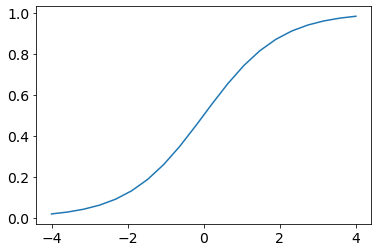

In [38]:
plt.plot(xx, yy)

si ponemos la función logística como función de una variable lineal con la variable medida, podemos "acomodar" la logística a cualquier escala

In [39]:
def logistic(x, a, b):
    t = a*x + b
    return 1 / (1+np.exp(-t))

In [40]:
xx = np.linspace(20, 90, 20)

In [41]:
xx * 0.08 - 4.5

array([-2.9       , -2.60526316, -2.31052632, -2.01578947, -1.72105263,
       -1.42631579, -1.13157895, -0.83684211, -0.54210526, -0.24736842,
        0.04736842,  0.34210526,  0.63684211,  0.93157895,  1.22631579,
        1.52105263,  1.81578947,  2.11052632,  2.40526316,  2.7       ])

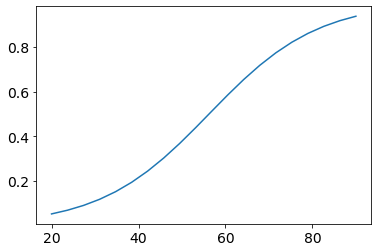

In [42]:
yy = logistic(xx, 0.08, -4.5)
plt.plot(xx, yy)

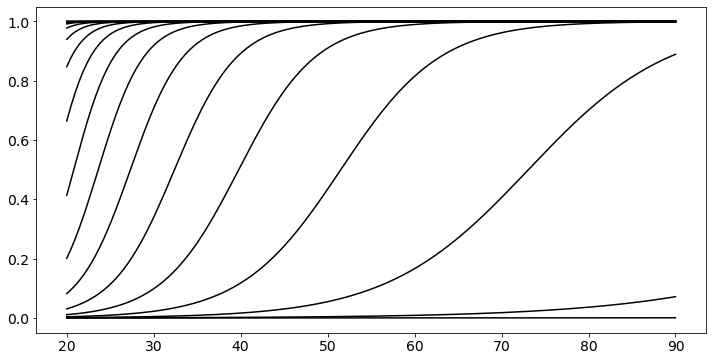

In [43]:
xx = np.linspace(20, 90, 150)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

for a in np.linspace(0.02, 1., 20):
    yy = logistic(xx, a, -9.)
    ax.plot(xx, yy, 'k')

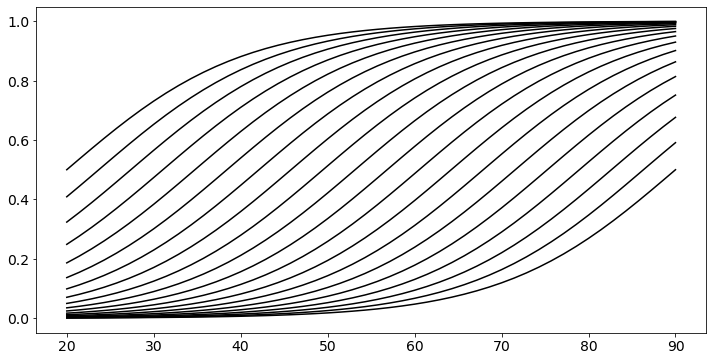

In [44]:
xx = np.linspace(20, 90, 50)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

for a in np.linspace(-9, -2, 20):
    yy = logistic(xx, 0.1, a)
    ax.plot(xx, yy, 'k')

Vamos a tratar de encontrar un clasificador con esta función